In [1]:
import os, re, random
import pandas as np
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Conv1D, MaxPool1D, Dropout, concatenate


2024-09-26 23:10:32.886953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
neg_docs = [
    re.sub(r"[^a-zA-Z\s]","",open(f"./txt_sentoken/neg/{file}").read())
    for file in os.listdir('./txt_sentoken/neg/')
]
pos_docs = [
    re.sub(r"[^a-zA-Z\s]","",open(f"./txt_sentoken/pos/{file}").read())
    for file in os.listdir('./txt_sentoken/pos/')
]

In [3]:
stop_words = [
    re.sub(r"[^a-zA-Z\s]","",word) 
    for word in stopwords.words('english')
]

In [4]:
neg_words = [
    list(filter(
        lambda x: (x not in stop_words and len(x) > 1),
        re.findall(r'\S+', doc)
    ))
    for doc in neg_docs
]
pos_words = [
    list(filter(
        lambda x: (x not in stop_words and len(x) > 1),
        re.findall(r'\S+', doc)
    ))
    for doc in pos_docs
]

In [5]:
#random.shuffle(neg_words)
#random.shuffle(pos_words)
len(neg_words)

1000

In [6]:
split_point = 800
neg_len = len(neg_words)
pos_len = len(pos_words)
train_x = pos_words[:split_point] + neg_words[:split_point]
train_y = [1 for _ in range(split_point)] + [0 for _ in range(split_point)]
test_x = pos_words[split_point:] + neg_words[split_point:]
test_y = [1 for _ in range(pos_len-split_point)] + [0 for _ in range(neg_len-split_point)]

In [7]:
tokenizer_train = Tokenizer()
tokenizer_train.fit_on_texts(train_x)
encoded_train = tokenizer_train.texts_to_sequences(train_x)
tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(test_x)
encoded_test = tokenizer_test.texts_to_sequences(test_x)

In [8]:
import pickle
with open('tokenizer_train.h5', 'wb') as f:
    pickle.dump(tokenizer_train, f)
with open('tokenizer_test.h5', 'wb') as f:
    pickle.dump(tokenizer_test, f)

In [9]:
dataset_maxlen = 0
for sen in pos_words + neg_words:
    if len(sen) > dataset_maxlen:
        dataset_maxlen = len(sen)
padded_train = pad_sequences(encoded_train, maxlen=dataset_maxlen, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=dataset_maxlen, padding='post')

In [10]:
vocab_len = len(tokenizer_train.word_index)+1
vocab_len

42053

In [11]:

def create_layers(input_layer, kernel_size):
   embedding_layer = Embedding(vocab_len, 100)(input_layer)
   conv_layer = Conv1D(filters=32, kernel_size=kernel_size, activation='relu')(embedding_layer)
   drop_layer = Dropout(0.5)(conv_layer)
   pool_layer = MaxPool1D(pool_size=2)(drop_layer)
   flat_layer = Flatten()(pool_layer)
   return flat_layer

# Create inputs and flattened layers using list comprehension
input1 = Input(shape=(dataset_maxlen,))
flat1 = create_layers(input1, 4)

input2 = Input(shape=(dataset_maxlen,))
flat2 = create_layers(input2, 6)

input3 = Input(shape=(dataset_maxlen,))
flat3 = create_layers(input3, 8)

input4 = Input(shape=(dataset_maxlen,))
flat4 = create_layers(input4, 10)

conc = concatenate([flat1, flat2, flat3, flat4])

# Create dense layers
dense1 = Dense(10, activation='relu')(conc)
output = Dense(1, activation='sigmoid')(dense1)

# Create model
model = Model(inputs=[input1, input2, input3, input4], outputs=[output])

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

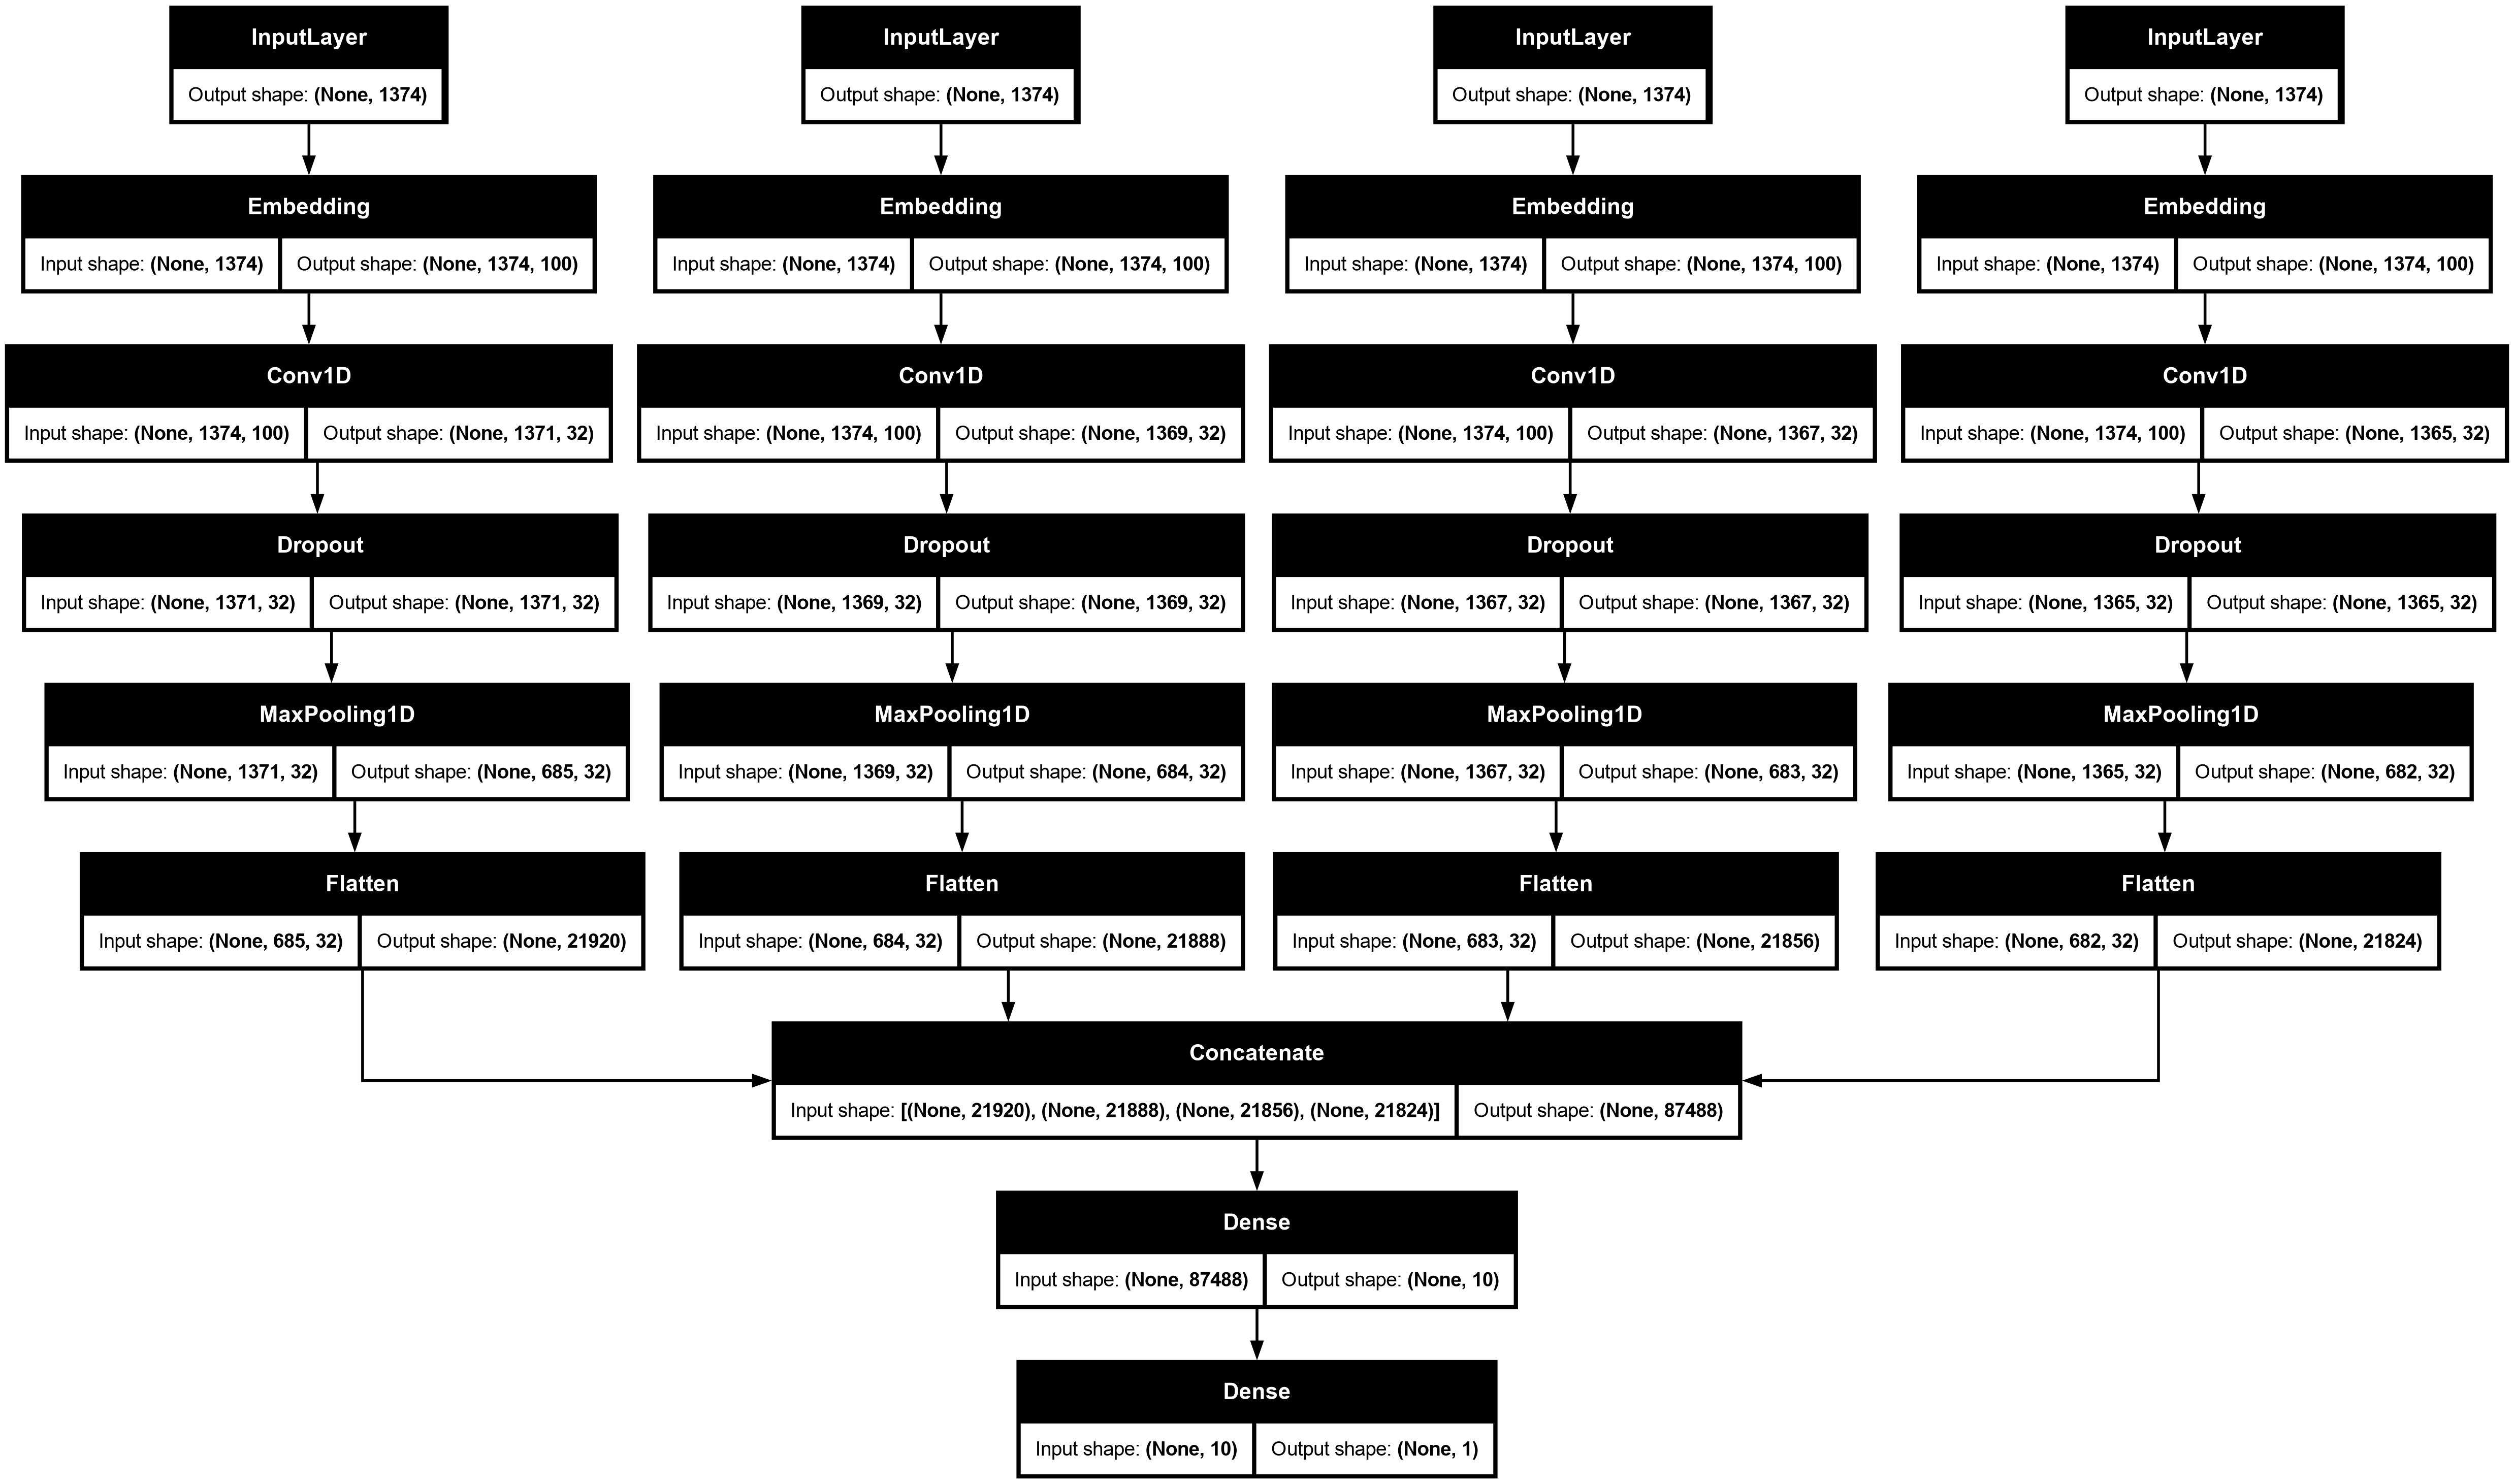

In [13]:
plot_model(model, show_shapes=True)

In [14]:
padded_train.shape

(1600, 1374)

In [15]:
len(padded_train)

1600

In [16]:
import tensorflow as tf

In [17]:
model.fit(
    [
        tf.convert_to_tensor(padded_train),
        tf.convert_to_tensor(padded_train),
        tf.convert_to_tensor(padded_train),
        tf.convert_to_tensor(padded_train)
    ], 
    tf.convert_to_tensor(train_y), 
    epochs=4, 
    batch_size=20, 
    validation_data=(
        [
            tf.convert_to_tensor(padded_test),
            tf.convert_to_tensor(padded_test),
            tf.convert_to_tensor(padded_test),
            tf.convert_to_tensor(padded_test)
        ],
        tf.convert_to_tensor(test_y)
    )
)

Epoch 1/4


2024-09-26 23:10:45.425200: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30620800 exceeds 10% of free system memory.
2024-09-26 23:10:45.428505: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32760000 exceeds 10% of free system memory.
2024-09-26 23:10:45.589798: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28516800 exceeds 10% of free system memory.
2024-09-26 23:10:45.625875: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29570400 exceeds 10% of free system memory.


 1/80 ━━━━━━━━━━━━━━━━━━━━ 4:17 3s/step - accuracy: 0.6500 - loss: 0.6904

2024-09-26 23:10:45.804628: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32760000 exceeds 10% of free system memory.


80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.5397 - loss: 0.7384 - val_accuracy: 0.5750 - val_loss: 0.6845
Epoch 2/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 420ms/step - accuracy: 0.6287 - loss: 0.6333 - val_accuracy: 0.5950 - val_loss: 0.6786
Epoch 3/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.8204 - loss: 0.4894 - val_accuracy: 0.5100 - val_loss: 0.6883
Epoch 4/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 337ms/step - accuracy: 0.9685 - loss: 0.3623 - val_accuracy: 0.5625 - val_loss: 0.7962


In [18]:
model.save('textcnn.h5')

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model = load_model('textcnn.h5')